# Floodwater Depth Estimation Tool (FwDET) (Peter et al., 2020)

Google Earth Engine Implementation of the Floodwater Depth Estimation Tool (FwDET-GEE) for Rapid and Large Scale Flood Analysis




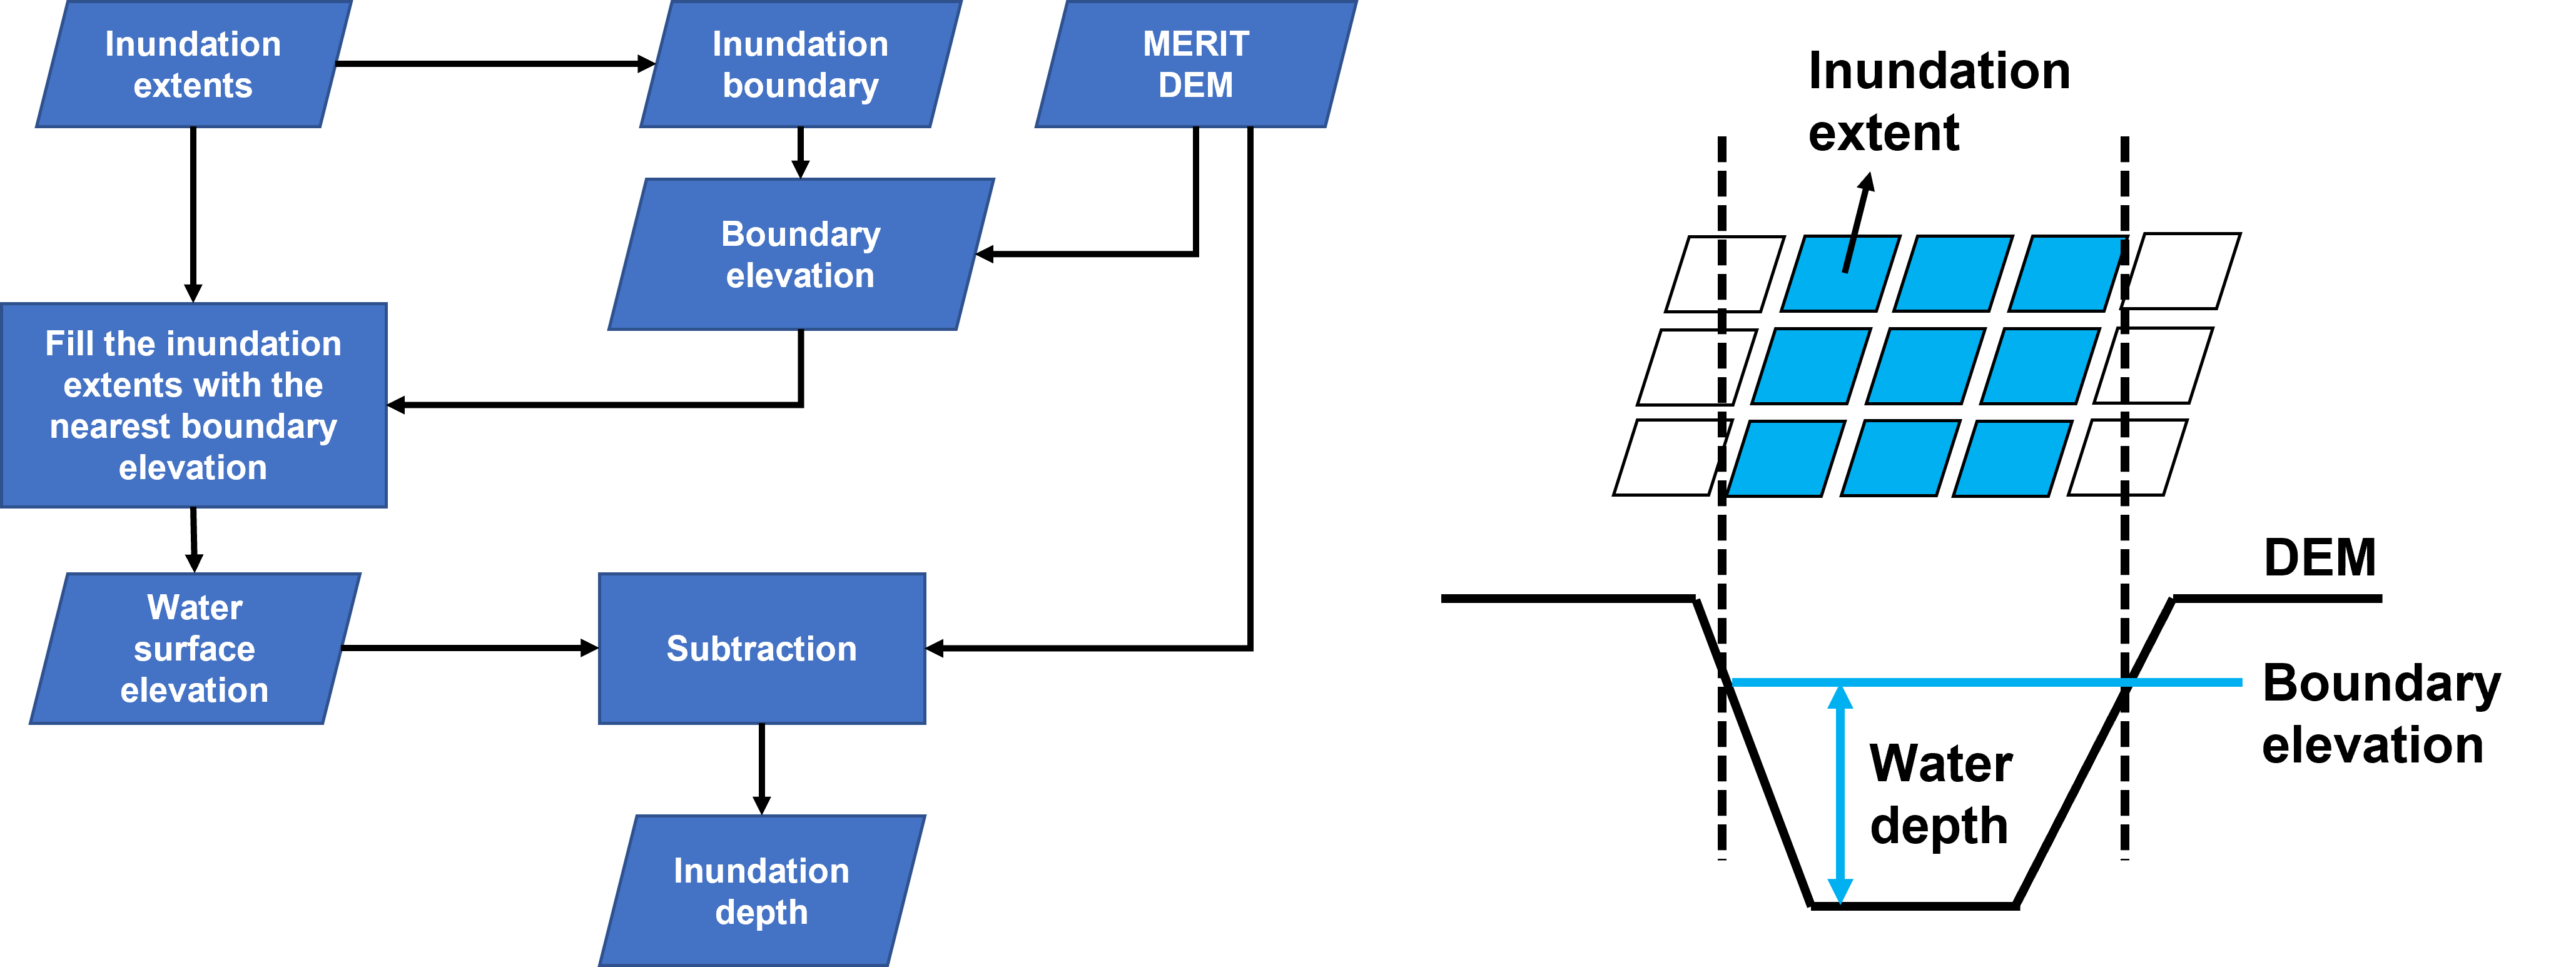

# Package installation and import

In [ ]:
!pip install \
     geemap \
     earthengine-api \
     xarray \
     rioxarray \
     rasterio

In [ ]:
%pylab inline

In [ ]:
import geemap
import ee

import xarray as xr

from google.colab import drive
import glob


In [ ]:
# ----- Mount your Google Drive to the Colab. This allows you to save data to your Google Drive -----
drive.mount('/content/drive')
root_output_folder = '/content/drive/MyDrive/FIER_Training_July2023' #Can be changed depending on users
try:
    os.makedirs(root_output_folder)
except:
    print('root output folder exists')

In [ ]:
ee.Authenticate()
ee.Initialize()

# FwDET-GEE function

In [ ]:
def generate_depth(flood_raster: ee.Image, aoi_geometry: ee.Geometry):

    # Please cite FwDET-GEE (Peter et al., 2020)
    # https://ieeexplore.ieee.org/document/9242297

    flood = ee.Image(flood_raster)

    flood = flood.clip(aoi_geometry.geometry())

    flood = flood.updateMask(flood.gte(1));
    area = flood.geometry().bounds().buffer(1000).bounds()

    dem = ee.Image('users/chihung/merit_dem_cogeo').clip(area)
    projection = dem.projection()
    dem = dem.updateMask(dem.gte(0))

    jrc = ee.Image('JRC/GSW1_4/GlobalSurfaceWater').select('transition').clip(area)
    water_image = jrc

    flood_image = flood.multiply(0)
    flood_image = flood_image.reproject(projection)

    w = water_image.reproject(projection)
    waterFill = flood_image.mask().where(w.eq(1),1)
    flood_image = waterFill.updateMask(waterFill.eq(1)).multiply(0)

    kernel = ee.Kernel.fixed(3,3,[[1,1,1],[1,1,1],[1,1,1]])
    kernel_weighted = ee.Kernel.fixed(3,3,[[1,1,1],[1,0,1],[1,1,1]])
    median = dem.focal_median(kernel = kernel).reproject(projection)
    median_weighted = dem.focal_median(kernel = kernel_weighted).reproject(projection)
    diff = dem.subtract(median)
    mzscore = diff.multiply(0.6745).divide(diff.abs().focal_median(kernel = kernel).reproject(projection))
    fillDEM = dem.where(mzscore.gt(3.5),median_weighted)
    expand = flood_image.focal_max(kernel = ee.Kernel.square(radius =  projection.nominalScale(), units= 'meters',)).reproject(projection)
    demMask = fillDEM.updateMask(flood_image.mask().eq(0))
    boundary = demMask.add(expand)
    medianBoundary = boundary.focal_median(kernel = kernel).reproject(projection)
    medianWeightedBoundary = boundary.focal_median(kernel = kernel_weighted).reproject(projection)
    diffBoundary = boundary.subtract(medianBoundary)
    mzscoreBoundary = diffBoundary.multiply(0.6745).divide(diffBoundary.abs().focal_median(kernel = kernel).reproject(projection))
    fill = fillDEM.where(mzscoreBoundary.gt(3.5),medianWeightedBoundary)

    mod = fill.updateMask(flood_image.mask().eq(0))
    source = mod.mask()
    val = 10000
    push = 5000
    cost0 = ee.Image(val).where(source,0).cumulativeCost(source,push)
    cost1 = ee.Image(val).where(source,1).cumulativeCost(source,push)
    cost2 = mod.unmask(val).cumulativeCost(source,push)
    costFill = cost2.subtract(cost0).divide(cost1.subtract(cost0))
    costSurface = mod.unmask(0).add(costFill)

    boxcar = ee.Kernel.square(radius = 3, units = 'pixels', normalize = True)
    costDepth = costSurface.subtract(fill).rename('FwDET_GEE').convolve(boxcar)\
    .reproject(projection).updateMask(flood_image.eq(0))


    costDepth = costSurface.subtract(fill).rename('FwDET_GEE').reproject(projection).updateMask(flood_image.eq(0))

    costDepthFilter = costDepth.where(costDepth.lt(0),0)
    costDepthFilter = costDepthFilter.updateMask(flood.mask())
    costDepthFilter = costDepthFilter.updateMask(costDepthFilter.neq(0))

    return costDepthFilter

# Flood depth estimation

We have prepared 1-18 days lead time of forecasted inundation extents, from 2022-10-15 to 2022-11-01.

In [ ]:
flood_depth_flist = glob.glob(root_output_folder+'/Day02/FIER_flood_maps/*.nc')
flood_depth_flist

In [ ]:
aoi_geometry = ee.FeatureCollection("users/chihung/FIER/LowerMekong")

flood_map_index=0

inundation_eeimg = geemap.netcdf_to_ee(flood_depth_flist[flood_map_index],  var_names = 'Inundation Map')
inundation_depth = generate_depth(inundation_eeimg, aoi_geometry)


## ----- To export the inundation depth (ee.Image) to your Google Drive -----
#task = ee.batch.Export.image.toDrive(**{
#  'image': inundation_depth,
#  'description': fname+'_depth_proj', # Filename, no need to include the extension
#  'folder':'FIER_Training_2023', # Which folder in your Google Drive the image will be exported to
#  'scale': 500, # Spatial resolution in meter
#  'region': ee.Image('users/chihung/merit_dem_cogeo').geometry().getInfo()['coordinates'], # AOI
#})
#task.start()


Visualization

In [ ]:
# ----- Visualization -----
vis_depth = {
    'min':0,
    'max':1,
    'palette':['white','lightblue','dodgerblue','blue','navy']
}
colors = vis_depth['palette']
vmin = vis_depth['min']
vmax = vis_depth['max']


Map = geemap.Map(center=(11.24,105.04), zoom=8)
Map.addLayer(inundation_depth, vis_depth,'Inundation Depth')
Map.add_colorbar_branca(colors=colors, vmin=vmin, vmax=vmax, layer_name='Inundation Depth')
Map.addLayerControl()
Map

# Acknowledgement

FwDET-GEE (Peter et al., 2020): https://ieeexplore.ieee.org/document/9242297